In [1]:
import torch
import random
from supervoice_hybrid import SupervoceHybridStage1, SentencePieceTextTokenizer
from train.dataset import load_sampler, create_async_loader
import matplotlib.pyplot as plt

/home/steve/miniconda3/envs/gym/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/steve/miniconda3/envs/gym/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [2]:
tokenizer = SentencePieceTextTokenizer("./tokenizer_text.model")
train_sampler = load_sampler("./external_datasets/libriheavy/libriheavy_cuts_small.jsonl.gz", "./external_datasets/libriheavy-encodec/", 1, tokenizer)
model = SupervoceHybridStage1()
checkpoint = torch.load("./output/hybrid/exp-2.pt", map_location = "cpu")
model.load_state_dict(checkpoint['model'])
model = model.cuda()

/tmp/ipykernel_73201/4255334000.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./output/hybrid/exp-2.pt", map_location = "cpu")


In [3]:
audio, text = train_sampler()

/data/notebooks/supervoice-hybrid/train/dataset.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded = torch.load(dir + id + ".pt")


In [4]:
min_duration = 75 * 3
max_duration = audio[0].shape[1] // 2 
if max_duration > min_duration:
    audio_split = random.randint(min_duration, max_duration)
else:
    audio_split = max_duration

text_condition = text[0].cuda()
audio_condition = audio[0][0, :audio_split].cuda()
audio_target = audio[0][0, audio_split:].cuda()
duration = audio[0].shape[1]
print(duration)

2091


In [5]:
model(condition_text = [text_condition, text_condition], condition_audio = [audio_condition, audio_condition], duration=[duration, duration], target = [audio_target, audio_target])

([tensor([[-6.9235, -3.7744, -6.7525,  ...,  1.0090,  1.8770, -2.3086],
          [-6.9875, -3.7773, -6.6578,  ...,  0.9688,  1.8688, -2.3613],
          [-6.9576, -3.7488, -6.7640,  ...,  0.9616,  1.9107, -2.3738],
          ...,
          [-6.9720, -3.7628, -6.7371,  ...,  0.9449,  1.8067, -2.2506],
          [-7.0225, -3.7360, -6.7321,  ...,  0.9831,  1.8382, -2.2413],
          [-6.9985, -3.7410, -6.7922,  ...,  0.9196,  1.9067, -2.3655]],
         device='cuda:0', grad_fn=<SliceBackward0>),
  tensor([[-7.0450, -3.7107, -6.6506,  ...,  0.9801,  1.8063, -2.3910],
          [-7.0486, -3.7840, -6.6688,  ...,  0.9623,  1.8643, -2.3392],
          [-7.0159, -3.7242, -6.7261,  ...,  0.9943,  1.8735, -2.2745],
          ...,
          [-7.0393, -3.7521, -6.7382,  ...,  0.9660,  1.9505, -2.3848],
          [-6.9495, -3.7478, -6.7454,  ...,  0.9449,  1.8666, -2.3194],
          [-7.0103, -3.6994, -6.7509,  ...,  0.9266,  1.8650, -2.3503]],
         device='cuda:0', grad_fn=<SliceBackward0>)

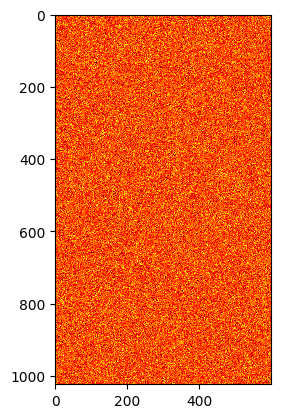

In [7]:
plt.imshow(model.positional_embedding_text.weight.T[:,:600].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()